In [69]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In [70]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
BATCH_SIZE = 1
HEIGHT = 256
WIDTH = 256
EPOCHS = 20
LEARNING_RATE = 0.0001

In [72]:
clean_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\play_set\clean"
noise_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\play_set\noise"

In [73]:
def conv_block(ip, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(ip)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

In [74]:
def encoder_block(ip, num_filters):
        x = conv_block(ip, num_filters)
        p = MaxPool2D((2, 2))(x)
        return p, x

In [75]:
def decoder_block(ip, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(ip)
    # Resize x to match skip if their shapes mismatch
    if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
        x = tf.image.resize(x, (skip.shape[1], skip.shape[2]))
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [76]:
def unet(ip_shape):
    ip = Input(ip_shape)

    s1, p1 = encoder_block(ip, 64)
    s2, p2 = encoder_block(p1, 96)
    s3, p3 = encoder_block(p2, 128)

    b1 = conv_block(p3, 224)

    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 96)
    d3 = decoder_block(d2, s1, 64)

    op = Conv2D(3, 1, padding="same", activation="sigmoid")(d3)
    op = tf.image.resize(op, (ip_shape[0], ip_shape[1]))

    model = Model(ip, op, name="UNET")

    return model

In [77]:
def load_images(img_dir, mask_dir):
    img_paths = sorted(glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*")))

    return img_paths, mask_paths

In [78]:
def read_image(path):
        path = path.decode()
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (WIDTH, HEIGHT))
        x = x/255.0
        return x

In [79]:
def tf_parse(x, y):
        def _parse(x, y):
                x = read_image(x)
                y = read_image(y)
                return x, y
        
        x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
        x.set_shape([HEIGHT, WIDTH, 3])
        y.set_shape([HEIGHT, WIDTH, 3])

        return x, y

In [80]:
def tf_dataset(x, y, batch=4):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [81]:
images, masks = load_images(noise_path, clean_path)

x_train, x_val, y_train, y_val= train_test_split(images, masks, test_size=0.2, random_state=1)

In [82]:
train_dataset = tf_dataset(x_train, y_train, batch=BATCH_SIZE)
val_dataset = tf_dataset(x_val, y_val, batch=BATCH_SIZE)

In [83]:
for x, y in train_dataset:
        print(x.shape, y.shape)

(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)


In [84]:
input_shape = (HEIGHT, WIDTH, 3)
model = unet(input_shape)

In [85]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 256, 256, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                              

In [86]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

In [87]:
callbacks = [
        # ModelCheckpoint(model, save_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

In [88]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks, batch_size=BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 25s 325ms/step - loss: 0.6876 - accuracy: 0.3071 - val_loss: 0.6875 - val_accuracy: 0.3833 - lr: 1.0000e-04
Epoch 2/20
20/20 [==============================] - 6s 287ms/step - loss: 0.6431 - accuracy: 0.4004 - val_loss: 0.6867 - val_accuracy: 0.4788 - lr: 1.0000e-04
Epoch 3/20
20/20 [==============================] - 6s 289ms/step - loss: 0.6192 - accuracy: 0.4517 - val_loss: 0.6907 - val_accuracy: 0.5391 - lr: 1.0000e-04
Epoch 4/20
20/20 [==============================] - 6s 288ms/step - loss: 0.6064 - accuracy: 0.4865 - val_loss: 0.7100 - val_accuracy: 0.5399 - lr: 1.0000e-04
Epoch 5/20
20/20 [==============================] - 6s 289ms/step - loss: 0.5984 - accuracy: 0.5125 - val_loss: 0.7113 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 6/20
20/20 [==============================] - 6s 297ms/step - loss: 0.5945 - accuracy: 0.5351 - val_loss: 0.7123 - val_accuracy: 0.4911 - lr: 1.0000e-04
Epoch 7/20
20/20 [===========================

In [90]:
test_img = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\play_set\noise\0001.png"

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def predict_and_visualize(model, image_path):
    """
    Predicts and visualizes the original noisy image and the denoised prediction.
    
    Args:
        model: Trained U-Net model.
        image_path: Path to the test image (noisy).
    """
    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255.0  # Normalize to [0,1]
    img_input = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Predict using the model
    pred = model.predict(img_input)[0]  # Remove batch dimension
    
    # Normalize prediction from [0,1] to [0,255]
    pred = np.clip(pred * 255.0, 0, 255).astype(np.uint8)
    
    # Convert grayscale prediction to 3 channels for visualization
    if pred.shape[-1] == 1:
        pred = np.squeeze(pred, axis=-1)  # Remove last channel
        pred = np.stack([pred]*3, axis=-1)  # Convert to 3-channel image
    
    # Convert original image to uint8 for better visualization
    img = (img * 255).astype(np.uint8)
    
    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Original Noisy Image")
    axes[0].axis("off")
    
    axes[1].imshow(pred)
    axes[1].set_title("Denoised Prediction")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 39ms/step


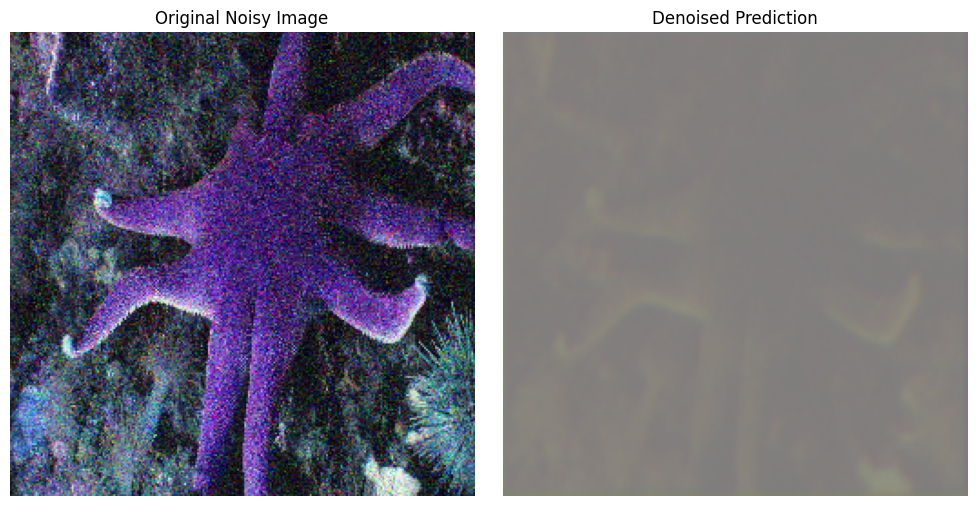

In [101]:
predict_and_visualize(model, test_img)